In [1]:
! pip3 install torch torchvision torchaudio
! pip3 install numpy
! pip3  install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchvision
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from MS_SSIM_L1_loss import MS_SSIM_L1_LOSS
from processing import grey_to_rgb, get_latest_epoch, resume, checkpoint, imshow, get_epoch

### Autoencoder definition:

In [3]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Activation functions
        self.relu = nn.LeakyReLU(0.01)
        self.tanh = nn.Tanh()
        # Encoder
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)  # 320*256 -> 160*128
        self.bn1 = nn.BatchNorm2d(8,momentum =0.5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)  # 160*128 -> 80*64
        self.bn2 = nn.BatchNorm2d(16,momentum = 0.5)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)  # 80*64 -> 40*32
        self.bn3 = nn.BatchNorm2d(32,momentum =0.5)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # 40*32 -> 20*16
        self.bn4 = nn.BatchNorm2d(64,momentum =0.5)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # 20*16 -> 10*8
        self.bn5 = nn.BatchNorm2d(128,momentum =0.5)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) # 10*8 -> 5*4
        self.encoder = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn5,
            self.relu,
            nn.Flatten(),
            nn.Linear(128 * 5 * 4, 1024),
        )

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding =1)  # 5*4 -> 10*8
        self.t_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding =1)  # 10*8 -> 20*16
        self.t_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding =1)  # 20*16 -> 40*32
        self.t_conv4 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)  # 40*32 -> 80*64
        self.t_conv5 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding =1)  # 80*64 -> 160*128
        self.t_conv6 = nn.ConvTranspose2d(8, 3, kernel_size=3,stride=2,padding=1, output_padding =1) # 160*128 -> 320*256
        self.linear = nn.Sequential(nn.Linear(1024, 128 * 5 * 4), self.relu)
        self.decoder = nn.Sequential(
            self.t_conv1,
            self.bn5,
            self.relu,
            self.t_conv2,
            self.bn4,
            self.relu,
            self.t_conv3,
            self.bn3,
            self.relu,
            self.t_conv4,
            self.bn2,
            self.relu,
            self.t_conv5,
            self.bn1,
            self.relu,
            self.t_conv6,
            self.tanh,
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x) # ->[B,128, 5, 4]
        x = self.linear(x)
        x = x.reshape(-1, 128, 5, 4)
        x = self.decoder(x)
        return x

### Setting parameters:

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"""
User Inputs
"""
# number of epochs for training
num_epoch = 50
# Loading checkpoint
checkpoint_dir = "./checkpoints"
loading_epoch = get_latest_epoch(checkpoint_dir)
# batch size
batch_size = 128
"""
End of User Inputs
"""
# Load the dataset
transform = transforms.Compose(
    [   transforms.ToTensor(),
        transforms.Resize((320, 256), antialias=True),
        transforms.Lambda(grey_to_rgb),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    ]
)
dataset = datasets.Caltech256(
    "./DATA",
    download=True,
    transform=transform,
)
# random seed
random_seed = torch.Generator().manual_seed(42)
# split train and test
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=random_seed)
# dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)
# check the shape of the data
trainiter = iter(trainloader)
img, label = next(trainiter)
print(img.shape, label.shape) # torch.Size([64, 3, 96, 192]) torch.Size([64])
"""
Model params
"""
model = Autoencoder()
if loading_epoch != 0:
    resume(model, f"{str(checkpoint_dir)}/MS_SSIM_L1-epoch-{str(loading_epoch)}.pth")
    print(f"start training from epoch {str(loading_epoch)}")
else:
    print("No checkpoint found, start training from scratch")
    loading_epoch = 0
total_epoch = num_epoch + loading_epoch
# Move to device
model = model.to(device)
# Set parameters
criterion = MS_SSIM_L1_LOSS()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

1183006720it [00:21, 55962277.76it/s]


Extracting ./DATA/caltech256/256_ObjectCategories.tar to ./DATA/caltech256
torch.Size([128, 3, 320, 256]) torch.Size([128])
start training from epoch 20


### Training:

In [5]:
model.train()
start_time = time.time()
for e in range(loading_epoch+1, total_epoch+1):
    epoch_loss = 0
    for i, (img_in, _) in enumerate(trainloader):
        img_in = img_in.to(device)
        optimizer.zero_grad()
        img_out = model(img_in)
        loss = criterion(img_in, img_out)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if (i + 1) % 50 == 0:
            print(
                f"Epoch [{e}/{total_epoch}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}"
            )
    print(f'average loss for epoch {e} is {epoch_loss/len(trainloader):.4f}')
    if e % 10 == 0:
        checkpoint(model, f"{checkpoint_dir+'/'}MS_SSIM_L1-epoch-{e}.pth")
print("Finished Training in time", (time.time() - start_time) / 60, "mins")

Epoch [21/70], Step [50/192], Loss: 42.2733
Epoch [21/70], Step [100/192], Loss: 43.0008
Epoch [21/70], Step [150/192], Loss: 42.8379
average loss for epoch 21 is 41.7279
Epoch [22/70], Step [50/192], Loss: 42.2559
Epoch [22/70], Step [100/192], Loss: 43.6699
Epoch [22/70], Step [150/192], Loss: 43.0913
average loss for epoch 22 is 41.6634
Epoch [23/70], Step [50/192], Loss: 38.3507
Epoch [23/70], Step [100/192], Loss: 39.3529
Epoch [23/70], Step [150/192], Loss: 39.5467
average loss for epoch 23 is 41.5301
Epoch [24/70], Step [50/192], Loss: 38.4353
Epoch [24/70], Step [100/192], Loss: 41.2758
Epoch [24/70], Step [150/192], Loss: 48.8368
average loss for epoch 24 is 41.3152
Epoch [25/70], Step [50/192], Loss: 41.3587
Epoch [25/70], Step [100/192], Loss: 42.5278
Epoch [25/70], Step [150/192], Loss: 43.1593
average loss for epoch 25 is 41.2573
Epoch [26/70], Step [50/192], Loss: 49.4170
Epoch [26/70], Step [100/192], Loss: 40.0945
Epoch [26/70], Step [150/192], Loss: 42.6617
average los

### Testing:

loading epoch 70 for testing


Input image(ABOVE) vs Reconstructed image(BELOW), for batch:[10/192]


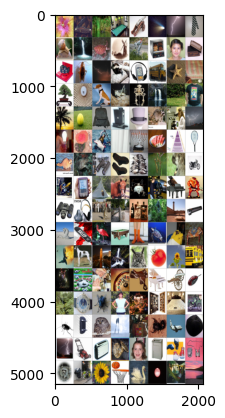

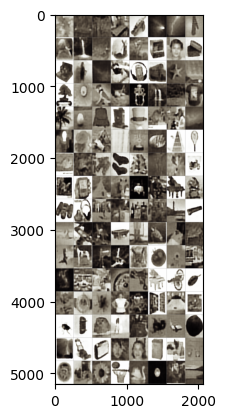

Loss: 37.7598




Input image(ABOVE) vs Reconstructed image(BELOW), for batch:[20/192]


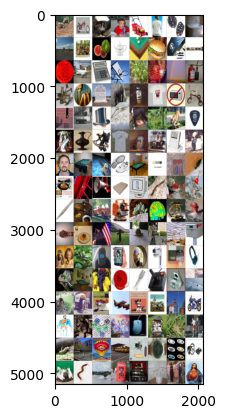

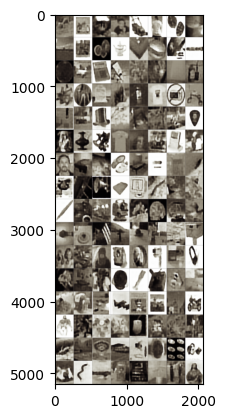

Loss: 39.3680




Input image(ABOVE) vs Reconstructed image(BELOW), for batch:[30/192]


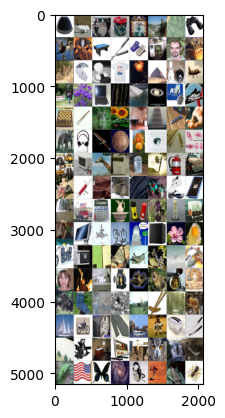

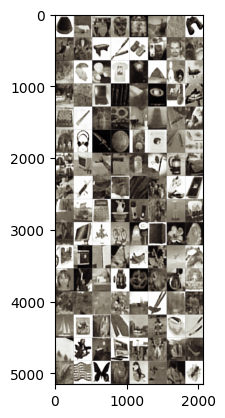

Loss: 38.0601




Input image(ABOVE) vs Reconstructed image(BELOW), for batch:[40/192]


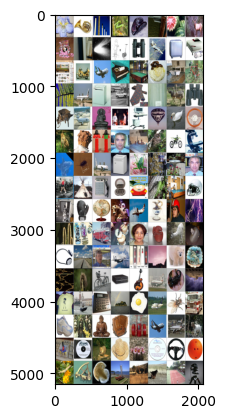

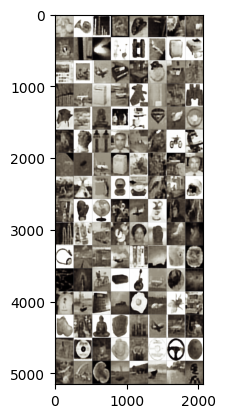

Loss: 39.5218




In [7]:
# Load the latest checkpoint
loading_epoch = get_latest_epoch(checkpoint_dir)
print(f"loading epoch {loading_epoch} for testing")
resume(model, f"{str(checkpoint_dir)}/MS_SSIM_L1-epoch-{loading_epoch}.pth")
# Dummy forward pass with train mode to enable batchnorm
model = model.to(device)
# testing the model
model.train()
for i, (img_in, _ )in enumerate(testloader):
    with torch.no_grad():
        img_out = model(img_in.to(device))
        loss = criterion(img_in.to(device), img_out.to(device)) 
    if (i+1) % 10 == 0:
       print (f"Input image(ABOVE) vs Reconstructed image(BELOW), for batch:[{i+1}/{len(trainloader)}]")
       imshow(torchvision.utils.make_grid(img_in.to("cpu")))
       imshow(torchvision.utils.make_grid(img_out.to("cpu")))
       print(f"Loss: {loss.item():.4f}")
       print("\n")

 checkpoints found: ['MS_SSIM_L1-epoch-20.pth', 'MS_SSIM_L1-epoch-30.pth', 'MS_SSIM_L1-epoch-40.pth', 'MS_SSIM_L1-epoch-50.pth', 'MS_SSIM_L1-epoch-60.pth', 'MS_SSIM_L1-epoch-70.pth']


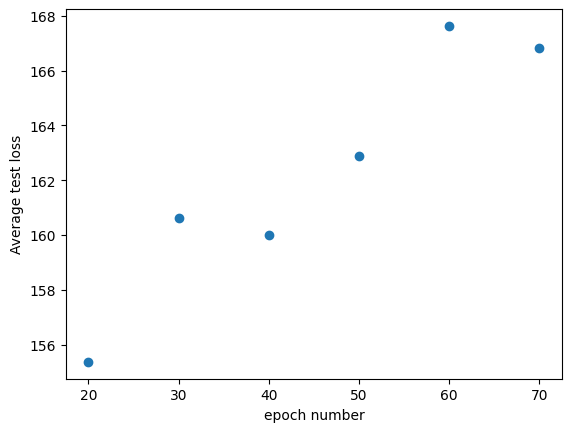

In [8]:
checkpoint_loss =[]
epoch_number = []
checkpoints = os.listdir(checkpoint_dir)
checkppoints = checkpoints.sort()
print(f' checkpoints found: {checkpoints}')
model = model.to(device)
# running the model on evaluation mode
model.eval()
for c in checkpoints:
    resume(model, f"{str(checkpoint_dir)}/{c}")
    c_loss = 0
    for (img_in, _ )in testloader:
        with torch.no_grad():
            img_out = model(img_in.to(device))
            loss = criterion(img_in.to(device), img_out.to(device))
            c_loss += loss.item()
    checkpoint_loss.append(c_loss/len(testloader))
    epoch_number.append(get_epoch(c))
plt.scatter(epoch_number, checkpoint_loss)
plt.xlabel("epoch number")
plt.ylabel("Average test loss")
plt.show()